In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

#### Import datasets

In [2]:
fluos = pd.read_csv('datasets/induction_matrix/induction_fluo.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]

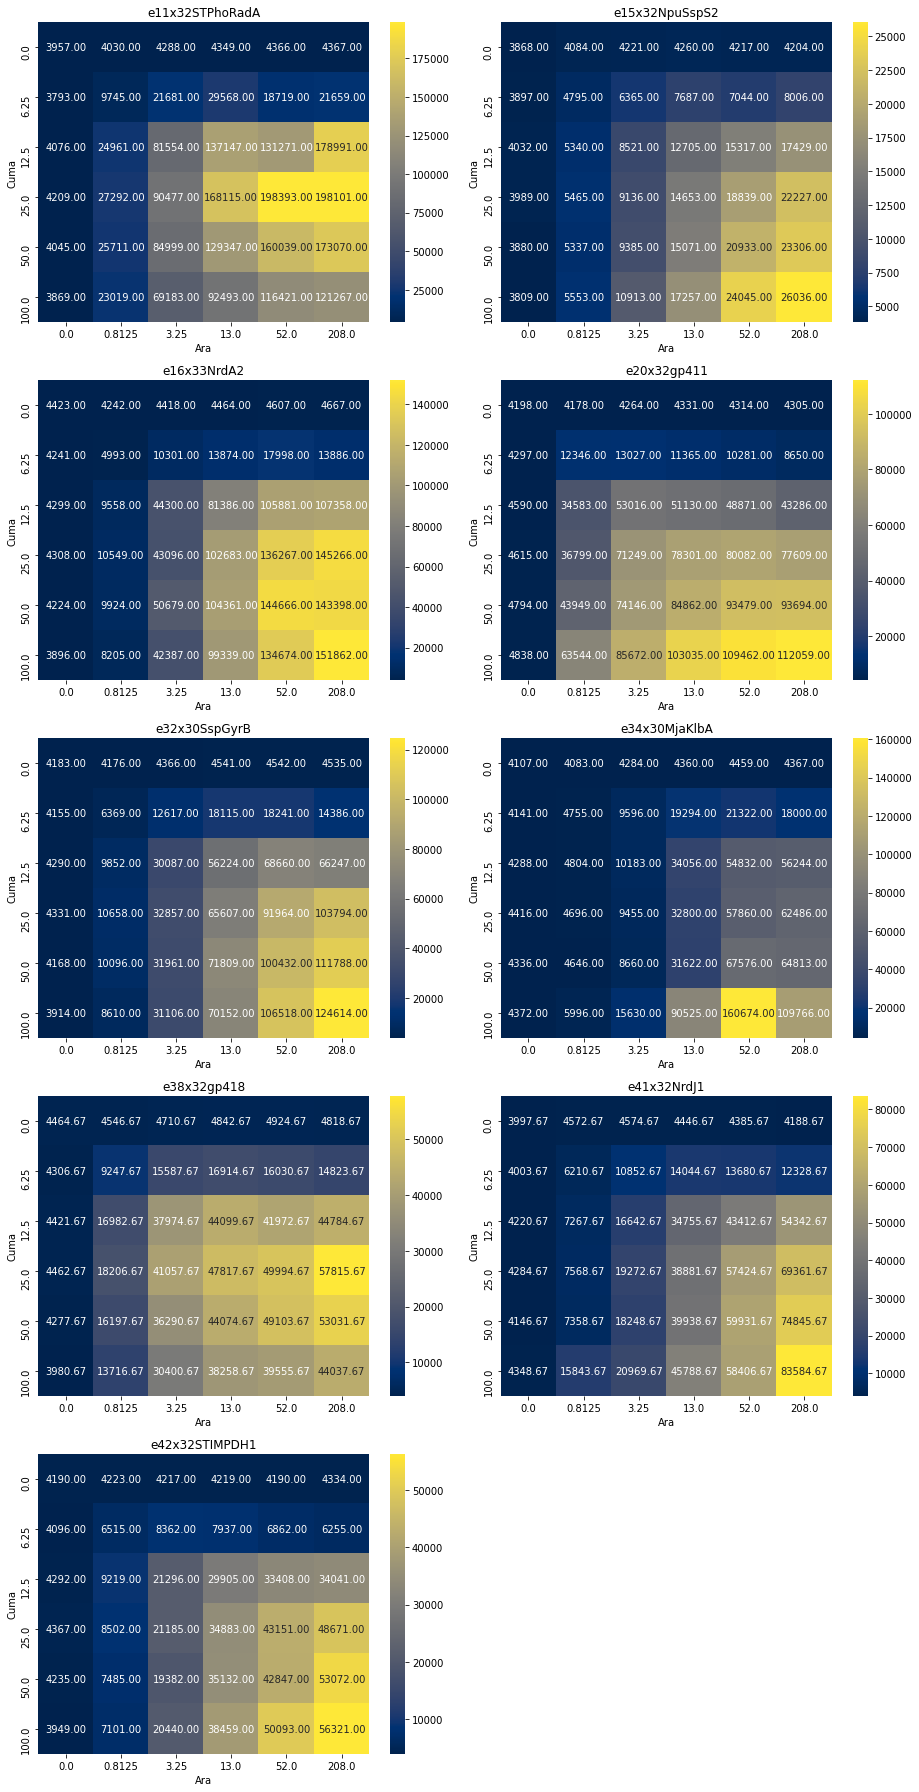

In [24]:
def plot_heatmap(fluos, gates, num_row, num_col, t=1440):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(13, num_row*5))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
            fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
            fluo_t['cuma'] = fluo_t['gate'].str[-2]
            fluo_t['ara'] = fluo_t['gate'].str[-1]
            fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', t)
            fluo_pvt.index = cumas
            fluo_pvt.columns = aras
            sns.heatmap(fluo_pvt, annot=True, fmt='.2f', ax=ax, cmap='cividis')
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(gate)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
plot_heatmap(fluos, gates, 5, 2)

#### Static Models

In [6]:
#simplified
def hill_activation(x, K, n, ymin):
    
    return ymin + (1 - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1) * hill_activation(x2, K2, n2, ymin2)

#### Modeling a Single Gate

In [27]:
#objective function
def computeSSE(ts, data, p0, bounds, func):
    
    popt, _ = curve_fit(func, ts, data, p0=p0, bounds=bounds)
    sim = hill_activation_and(ts, *popt)
    
    return sum([(act - pred)**2 for act, pred in zip(data, sim)])

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, ts, data, bounds, func):
    
    init_guess = []
    for k in range(iterations):
        p0 = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(ts, data, p0, bounds, func)
        init_guess.append((error, p0))
    return sorted(init_guess)[0][1]

A single gate.

In [20]:
x1, x2 = np.meshgrid(cumas, aras)
x = np.vstack((x1.ravel(), x2.ravel()))

gate = gates[3]
fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]

y_ = fluo_t[1200]
y = y_ / y_.max()
#init_guess = [10, 10, 1, 1, y.min(), y.min()]
gate_bounds = [[1, 1, 1, 1, y.min()-0.01, y.min()-0.01],
           [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min()]]
init_guess = randomSearch(30, x, y, gate_bounds, hill_activation_and)

popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
gate, r2_score(y, hill_activation_and(x, *popt))

100%|██████████| 30/30 [00:00<00:00, 37.40it/s]


('e20x32gp411', 0.9809887649661219)

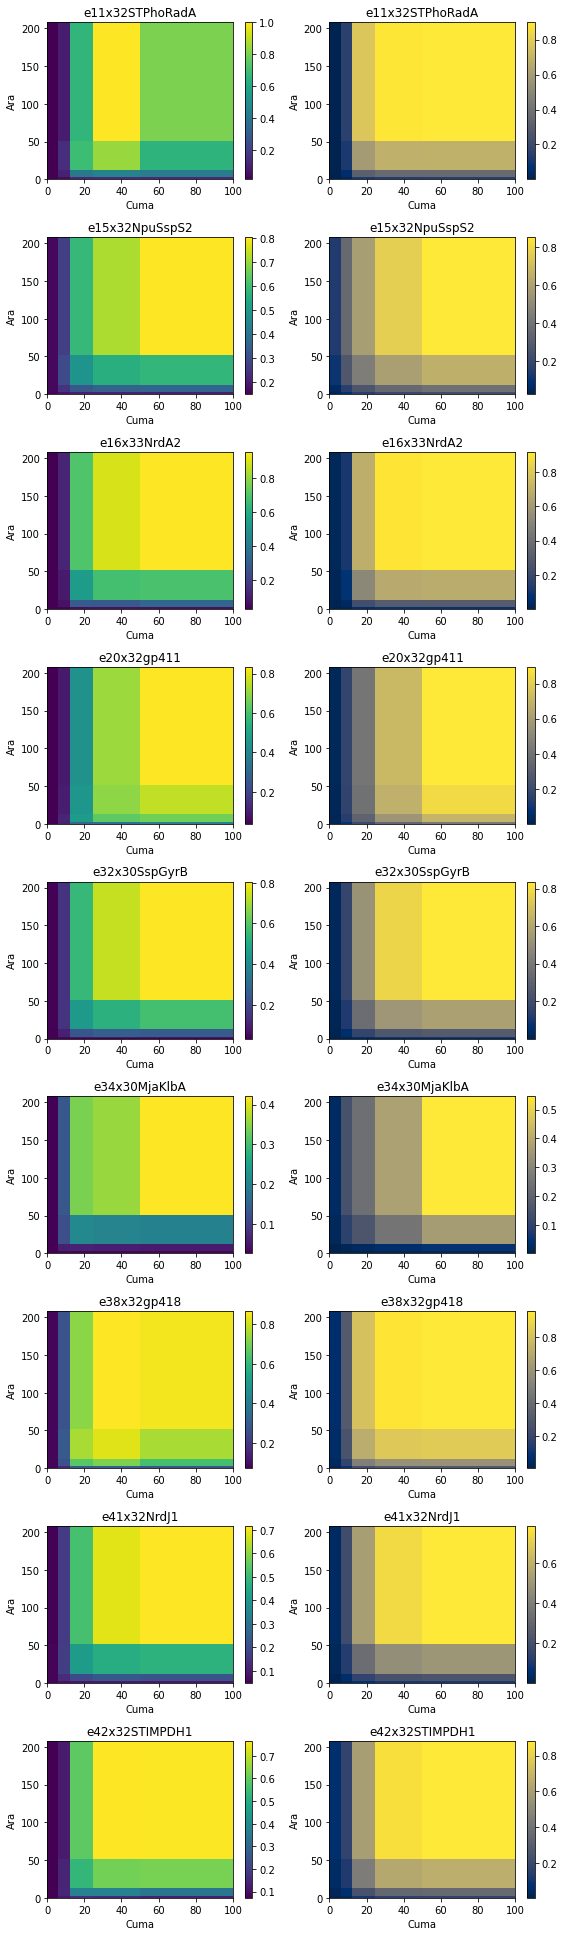

In [170]:
#simplified
real_data = []
predicted_data = []

x1, x2 = np.meshgrid(cumas, aras)
x = np.vstack((x1.ravel(), x2.ravel()))

def plot_hill_equation(fluos, gates, num_row, num_col, t=1440):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(8, num_row*3))
    for i, gate in enumerate(gates):
        
        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
        fluo_t['cuma'] = fluo_t['gate'].str[-2]
        fluo_t['ara'] = fluo_t['gate'].str[-1]

        y_ = fluo_t[t]
        y = y_ / y_.max()
        init_guess = [10, 10, 1, 1, y.min(), y.min()]
        gate_bounds = [[1, 1, 1, 1, y.min()-0.01, y.min()-0.01],
                       [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min()]]
        #init_guess = randomSearch(30, x, y, gate_bounds, hill_activation_and)
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
        
        fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', t)
        fluo_pvt.index = cumas
        fluo_pvt.columns = aras
        
        cf = axs[i, 0].pcolormesh(x1, x2, y.values.reshape(-1, 6), cmap='viridis')
        f.colorbar(cf, ax=axs[i, 0])
        axs[i, 0].set_xlabel('Cuma')
        axs[i, 0].set_ylabel('Ara')
        axs[i, 0].set_title(gate)
        
        cf = axs[i, 1].pcolormesh(x1, x2, hill_activation_and(x, *popt).reshape(-1, 6), cmap='cividis')
        f.colorbar(cf, ax=axs[i, 1])
        axs[i, 1].set_xlabel('Cuma')
        axs[i, 1].set_ylabel('Ara')
        axs[i, 1].set_title(gate)
    plt.tight_layout()
    plt.show()
    
plot_hill_equation(fluos, gates, 9, 2)

0.9015352671069898
0.9572158053852751
0.9954932267430735
0.9734474497932166
0.9867907834880668
0.8834082330961119
0.9198902141414065
0.9753684307534263
0.9695029521818102


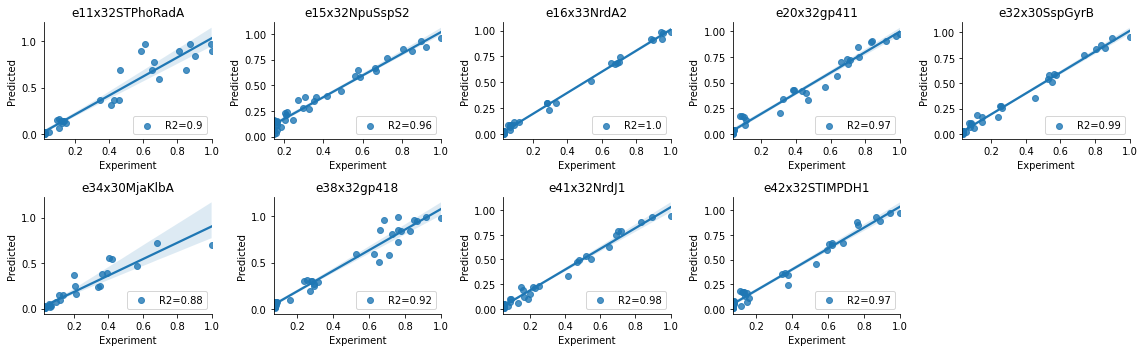

In [171]:
#simplified
#1440
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        sns.regplot(real_data[i].ravel(), predicted_data[i].ravel(), ax=ax, label='R2={}'.format(round(r2_score(real_data[i].ravel(), predicted_data[i].ravel()), 2)))
        print(r2_score(real_data[i].ravel(), predicted_data[i].ravel()))
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

0.9015352671071962
0.9572158053934158
0.995493226743076
0.9734474497932307
0.9867907834884003
0.8834082336860277
0.9198902141417613
0.9753684307538242
0.9695029521849045


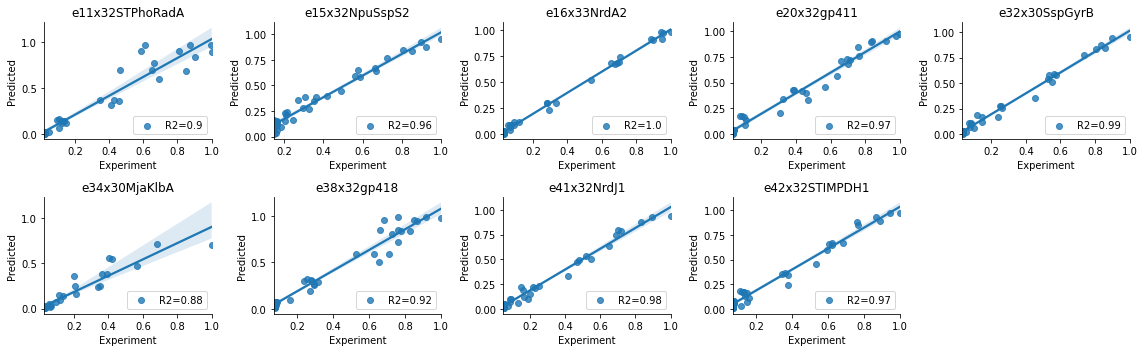

In [23]:
#simplified
#1440
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        sns.regplot(real_data[i].ravel(), predicted_data[i].ravel(), ax=ax, label='R2={}'.format(round(r2_score(real_data[i].ravel(), predicted_data[i].ravel()), 2)))
        print(r2_score(real_data[i].ravel(), predicted_data[i].ravel()))
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

### Multiple Datapoints Individually

In [33]:
#without sampling
real_datas = []
predicted_datas = []
popt_datas = []

for gate in tqdm(gates):
    
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    popt_data = []

    for i in range(0, 1460, 20):
        
        y_ = fluo_t[i]
        y_[y_ < 0] = 0.01
        y = y_ / y_.max()
        init_guess = [10, 10, 1, 1, y.min(), y.min()]
        gate_bounds = [[1, 1, 1, 1, y.min()-0.01, y.min()-0.01],
                   [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min()]]
        
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        popt_data.append(popt)
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
    
    popt_datas.append(popt_data)
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())

100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


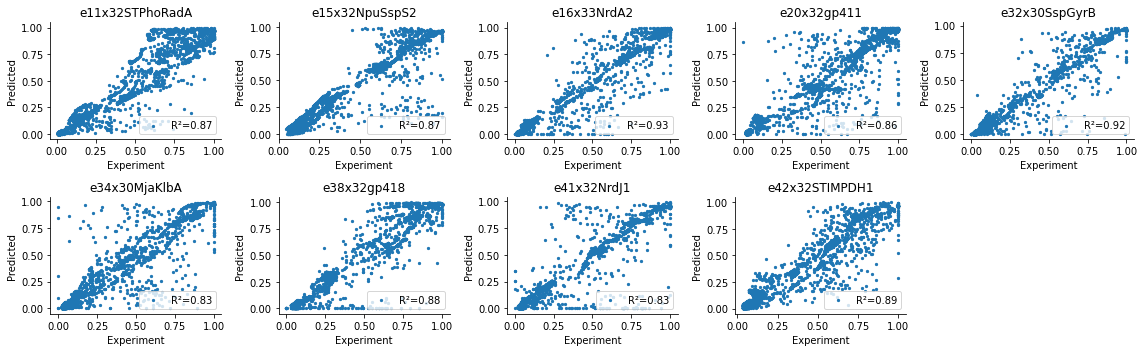

In [34]:
#simplified
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        r2 = 'R\u00b2={:.2f}'.format(r2_score(real_datas[i], predicted_datas[i]))
        ax.scatter(real_datas[i], predicted_datas[i], s=5, label=r2)
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

In [37]:
#with sampling
real_datas = []
predicted_datas = []
popt_datas = []

for gate in gates:
    
    print(gate)
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    popt_data = []

    for i in tqdm(range(0, 1460, 20)):
        
        y_ = fluo_t[i]
        y_[y_ < 0] = 0.01 #replace negative values
        y = y_ / y_.max()
        
        #init_guess = [10, 10, 1, 1, y.min(), y.min()]
        gate_bounds = [[1, 1, 1, 1, y.min()-0.01, y.min()-0.01],
                   [1e4, 1e4, 5, 5, y.min()+0.1, y.min()+0.1]]
        init_guess = randomSearch(30, x, y, gate_bounds, hill_activation_and)
        
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        popt_data.append(popt)
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
    
    popt_datas.append(popt_data)
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())

  0%|          | 0/73 [00:00<?, ?it/s]

e11x32STPhoRadA


  0%|          | 0/73 [00:00<?, ?it/s]

e15x32NpuSspS2


  0%|          | 0/73 [00:00<?, ?it/s]

e16x33NrdA2


  0%|          | 0/73 [00:00<?, ?it/s]

e20x32gp411


  0%|          | 0/73 [00:00<?, ?it/s]

e32x30SspGyrB


  0%|          | 0/73 [00:00<?, ?it/s]

e34x30MjaKlbA


  0%|          | 0/73 [00:00<?, ?it/s]

e38x32gp418


  0%|          | 0/73 [00:00<?, ?it/s]

e41x32NrdJ1


  0%|          | 0/73 [00:00<?, ?it/s]

e42x32STIMPDH1


100%|██████████| 73/73 [00:42<00:00,  1.73it/s]


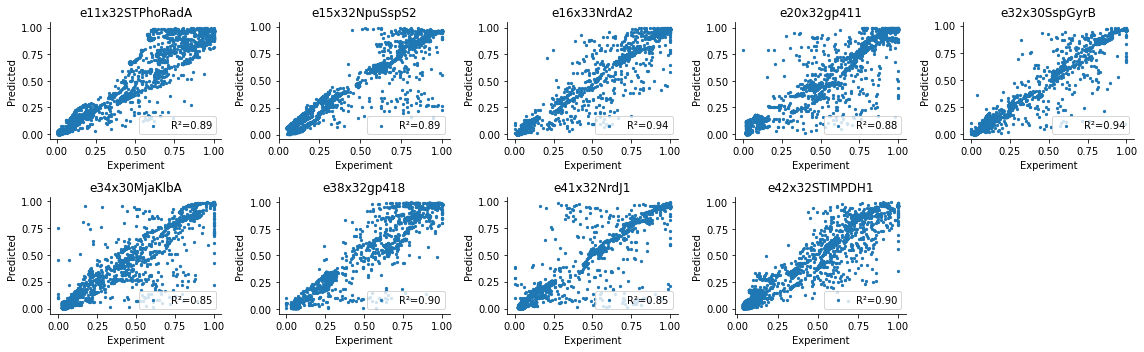

In [38]:
#simplified
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        r2 = 'R\u00b2={:.2f}'.format(r2_score(real_datas[i], predicted_datas[i]))
        ax.scatter(real_datas[i], predicted_datas[i], s=5, label=r2)
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

In [40]:
param_names = ['K1', 'K2', 'n1', 'n2', 'ymin1', 'ymin2']
df_params = pd.DataFrame()
for i in range(len(gates)):
    temp = pd.DataFrame(popt_datas[i], columns=param_names)
    temp['gate'] = gates[i]
    df_params = df_params.append(temp)

In [172]:
df_params

,K1,K2,n1,n2,ymin1,ymin2,gate
0,5.002259,1.000000,1.000000,1.067298,0.176087,0.176087,e11x32STPhoRadA
1,2.481118,1.000000,1.000000,1.055085,0.209560,0.209560,e11x32STPhoRadA
2,2.685386,1.000000,1.016861,1.119324,0.146667,0.146667,e11x32STPhoRadA
3,1.164450,1.000000,1.074784,1.036189,0.210236,0.210236,e11x32STPhoRadA
4,4.810758,1.000000,1.000000,1.000000,0.363042,0.363042,e11x32STPhoRadA
...,...,...,...,...,...,...,...
68,10.658609,7.802758,3.702119,1.000000,0.076955,0.085417,e42x32STIMPDH1
69,10.601453,7.655100,3.791068,1.000000,0.080215,0.086089,e42x32STIMPDH1
70,10.592604,7.727168,3.823340,1.000000,0.081969,0.087425,e42x32STIMPDH1
71,10.605888,7.682549,3.802707,1.000000,0.082927,0.087988,e42x32STIMPDH1


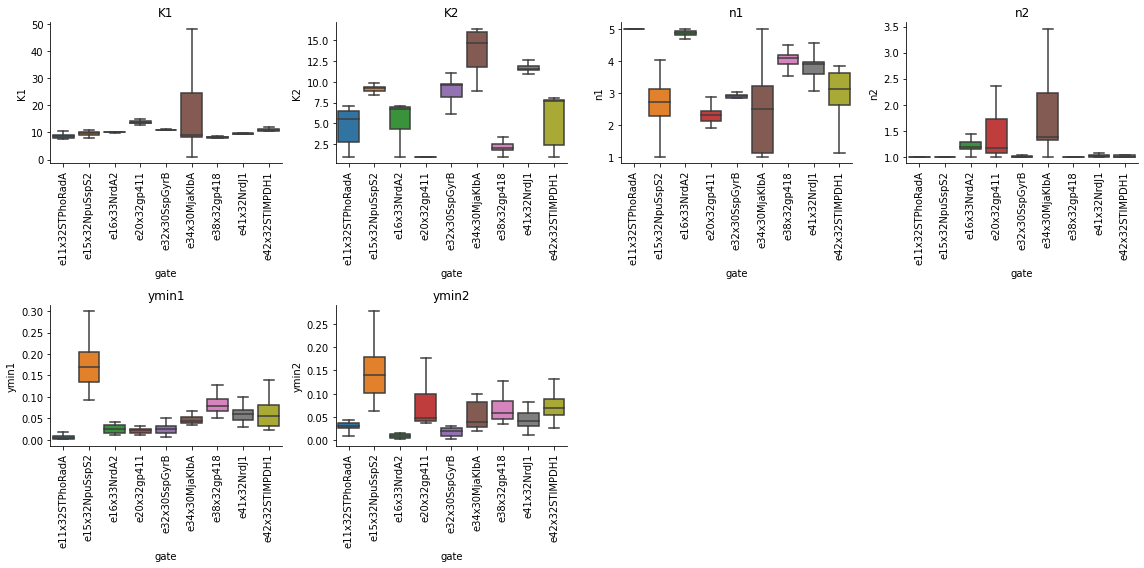

In [41]:
#simplified
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(16, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(param_names):
        single_param = df_params[['gate', param_names[i]]]
        sns.boxplot(x='gate', y=param_names[i], data=single_param, showfliers=False, ax=ax)
        ax.set_title(param_names[i])
        ax.set_xticklabels(gates, rotation=90)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

#### Fitting at the Same Time

In [84]:
(1460 - 0)/20

73.0

In [74]:
def fit_altogether():
    
    def hill_activation_combined(x, K1, K2, n1, n2, ymin1, ymin2):
        
        result = []
        for i in range(start, end, gap):
            temp = hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2)
            result = np.append(result, temp)   
        return result
    
    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    f_params = []
    
    #gate = 'e20x32gp411'
    for gate in tqdm(gates):
        
        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})

        y = pd.Series()
        start, end, gap = 0, 1460, 20
        dp = int((end-start)/gap)
        for t in range(start, end, gap):
            y_ = fluo_t[t]
            y_[y_ < 0] = 0.01 #replace negative values
            y_ = y_ / y_.max()
            y = y.append(y_)
        '''
        minmax_init = dp * [y.min(), y.min(), y.max(), y.max()]
        minmax_low = dp * [0, 0, 0, 0]
        minmax_up = dp * [y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]
        init_guess = np.append([10, 10, 1, 1], minmax_init)
        gate_bounds = [np.append([1, 1, 1, 1], minmax_low), np.append([1e5, 1e5, 7, 7], minmax_up)]
        '''
        
        #init_guess = [10, 10, 1, 1, y.min(), y.min()]
        gate_bounds = [[1, 1, 1, 1, y.min()-0.01, y.min()-0.01],
                   [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min()]]
        init_guess = randomSearch(30, x, y, gate_bounds, hill_activation_combined)
        '''

        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0], [1e4, 1e4, 6, 6, y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]]
        '''
        f_param, f_cov = curve_fit(hill_activation_combined, x, y, p0=init_guess, bounds=gate_bounds)
        f_params.append(f_param)
    
    return f_params
    
f_params = fit_altogether()

100%|██████████| 9/9 [01:16<00:00,  8.55s/it]


In [173]:
f_params

[array([8.38680853, 3.84392393, 4.30501956, 1.        , 0.01184109,
        0.01184109]),
 array([8.20222199, 4.67464108, 1.73242239, 1.        , 0.05220368,
        0.05220368]),
 array([9.57174920e+00, 4.75800002e+00, 3.29149699e+00, 1.00000000e+00,
        1.24528772e-04, 1.24528772e-04]),
 array([ 1.00000000e+04,  1.00000000e+04,  4.99999970e+00,  5.00000000e+00,
        -9.91957083e-03, -9.91957083e-03]),
 array([1.09046568e+01, 6.92019693e+00, 2.11424111e+00, 1.00000000e+00,
        1.04761905e-04, 1.04761905e-04]),
 array([9.00497302e+00, 1.12627795e+01, 1.07042777e+00, 1.06145561e+00,
        1.70985342e-04, 1.70985342e-04]),
 array([7.93284743e+00, 1.81047431e+00, 2.91066641e+00, 1.00000000e+00,
        9.34841544e-05, 9.34841544e-05]),
 array([8.80537280e+00, 9.83715294e+00, 2.76472383e+00, 1.00000000e+00,
        8.54920065e-05, 8.54920065e-05]),
 array([11.82699795,  2.87005849,  1.56293445,  1.        ,  0.03725758,
         0.03725758])]

In [76]:
#gate = gates[6]
real_datas = []
predicted_datas = []
for gate in gates:
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    for t in range(0, 1460, 20):
        train = fluo_t[t]
        train_max = train.max()
        train = train / train_max
        test = hill_activation_and(x, *f_params[6])
        real_data.append(train)
        predicted_data.append(test)
        
        #print(gate, t, r2_score(train, test))
    real_datas.append(np.array(real_data))
    predicted_datas.append(np.array(predicted_data))

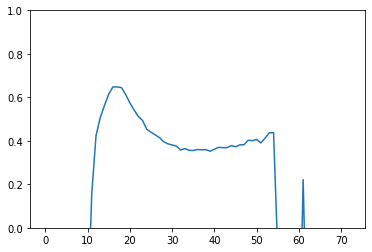

In [83]:
j = 5
pd.Series([r2_score(real_datas[j][i], predicted_datas[j][i]) for i in range(73)], name=gates[j]).plot()
plt.ylim([0, 1])
plt.show()

In [ ]:
gates[5]

In [ ]:
sns.regplot(train, test)

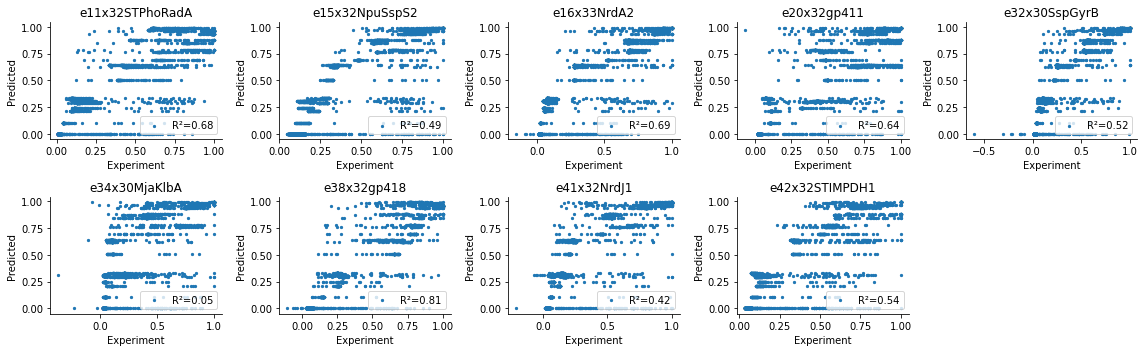

In [49]:
#simplified
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        r2 = 'R\u00b2={:.2f}'.format(r2_score(real_datas[i], predicted_datas[i]))
        ax.scatter(real_datas[i], predicted_datas[i], s=5, label=r2)
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

### Dynamic Models

In [3]:
#at 24h
hill_params = {
    "e11x32STPhoRadA": [7.751379398582397, 4.427659927105025, 5.4364526386293885, 0.5873372443737356, 0.026357728242060084, 0.01680295581836571],
    "e15x32NpuSspS2": [9.122794964185752, 7.95126898918161, 2.854331030124338, 0.7428008115777417, 0.24225805748380314, 0.14529290120106214],
    "e16x33NrdA2": [9.456147610278604, 4.829003115276247, 3.399067788351665, 0.9180175290039748, 0.0001180466610213445, 0.0001183997017730263],
    "e20x32gp411": [13.340390925220001, 0.7078045598325073, 1.5821013105488064, 1.443781472312746, 8.381111440835662e-05, 8.35575134509024e-05],
    "e32x30SspGyrB": [10.143418377363817, 7.755006659481948, 2.556574923604361, 0.7818272930493256, 9.935990160905705e-05, 9.974411223699253e-05],
    "e34x30MjaKlbA": [9.001458206633695, 11.428446854909668, 1.0933867514229008, 1.0600646629268158, 0.00016400682274533759, 0.00016305640231122334],
    "e38x32gp418": [7.441303103850044, 1.82254638736088, 3.562038228871342, 0.6259695334275842, 8.884856612166981e-05, 8.980397657011261e-05],
    "e41x32NrdJ1": [8.336137834104784, 10.574983054205797, 3.1622513338731513, 0.7874701934257659, 8.136439049687377e-05, 8.067038881909733e-05],
    "e42x32STIMPDH1": [10.468086042894893, 5.539277314971308, 2.884542350419205, 0.6606769497813666, 0.10609810015533172, 0.10871273740946648]
}

In [ ]:
#objective function
def computeSSE(ts, data, p0, bounds, func):
    
    def model_fit(t, r, y0, synGFP, degGFP):
        
        fit = gate_wrapper(t, r, y0, synGFP, degGFP, ind1, ind2, params)
        return fit[1]
    
    popt, _ = curve_fit(model_fit, ts, data, p0=p0, bounds=bounds)
    sim = model_fit(ts, *popt)
    
    
    
    return sum([(act - pred)**2 for act, pred in zip(data, sim)])

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, ts, data, bounds, func):
    
    init_guess = []
    for k in range(iterations):
        p0 = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(ts, data, p0, bounds, func)
        init_guess.append((error, p0))
    return sorted(init_guess)[0][1]

In [4]:
def gate_wrapper(t, r, y0, synGFP, degGFP, x1, x2, params):
    
    K1, K2, n1, n2, ymin1, ymin2 = params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2)
    
    def gate_model(y, t):
        y1, GFP = y
        dy1 = r * (1 - (y1/ymax)) * y1
        dGFP = synGFP * y1 - degGFP * GFP
        return [dy1, dGFP]
    
    solution = odeint(gate_model, [y0, 0], t)
    return solution.transpose()

def fit_simple(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo / fluo.max()
    
    parameters = ['r', 'y0', 'degGFP']
    init_guess = [0.1, 0.1, 0.02]
    gate_bounds_together = [[0, 1e-3, 0], [1e4, 1e4, 1e2]]
    #init_guess = randomSearch(20, f_t, f_data, gate_bounds_together, gate_wrapper)
    
    def model_fit(t, r, y0, degGFP):
        
        fit = gate_wrapper(t, r, y0, 1., degGFP, ind1, ind2, params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

e11x32STPhoRadA
e15x32NpuSspS2
e16x33NrdA2
e20x32gp411
e32x30SspGyrB
e34x30MjaKlbA
e38x32gp418
e41x32NrdJ1
e42x32STIMPDH1


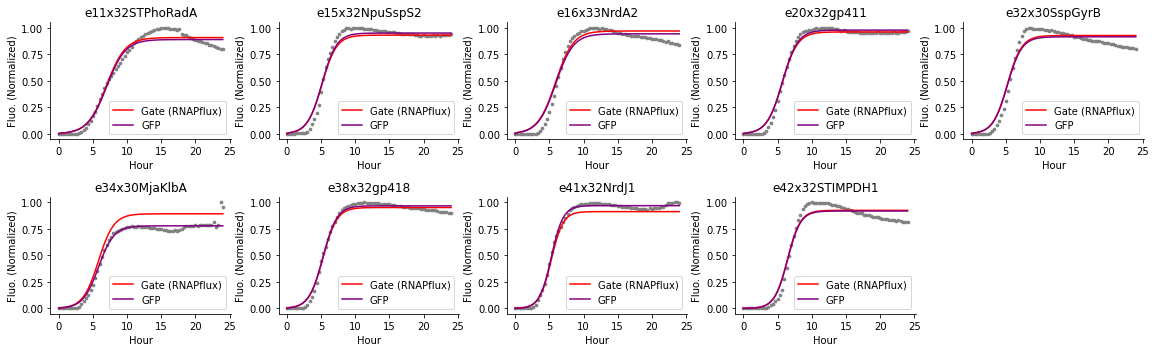

In [12]:
gate = 'e42x32STIMPDH1'
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        gate = gates[i]
        print(gate)
        a = 5
        b = 5
        cuma = cumas[a]
        ara = aras[b]
        fluo = fluos['{}_{}{}'.format(gate, a, b)]
        f_df, f_sim, f_data = fit_simple(fluo, cuma, ara, hill_params[gate])

        popt = f_df['Value'].tolist()
        sim = gate_wrapper(fluo.index, popt[0], popt[1], 1, popt[2], cuma, ara, hill_params[gate])
        ax.scatter(fluo.index/60, f_data, s=7, color='gray')
        ax.plot(fluo.index/60, sim[0], color='red', label='Gate (RNAPflux)')
        ax.plot(fluo.index/60, sim[1], color='purple', label='GFP')
        ax.set_title(gate)
        ax.set_ylabel('Fluo. (Normalized)')
        ax.set_xlabel('Hour')
        ax.legend()
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

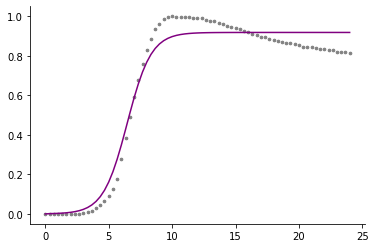

In [181]:
plt.scatter(fluo.index/60, f_data, s=7, color='gray')
plt.plot(fluo.index/60, f_sim, color='purple')
sns.despine()

In [182]:
f_df

,Parameters,Value,Err
0,r,0.017657,0.001482
1,y0,0.001002,0.000589
2,degGFP,1.006875,0.010758


In [ ]:
sim = gate_wrapper(fluo.index, 0.02, 0.01, 0.05, 0.005, cuma, ara, hill_params[gate])
plt.scatter(fluo.index/60, f_data, s=7, color='gray')
plt.plot(fluo.index/60, sim[0], color='red', label='gate')
plt.plot(fluo.index/60, sim[1], color='purple', label='GFP')
plt.legend()
sns.despine()

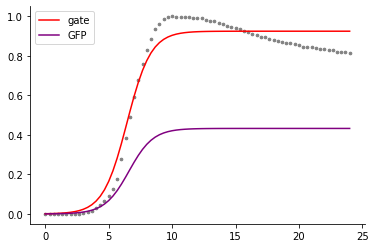

In [20]:
sim = gate_wrapper(fluo.index, 0.017657, 0.001002, 0.05, 0.106875, cuma, ara, hill_params[gate])
plt.scatter(fluo.index/60, f_data, s=7, color='gray')
plt.plot(fluo.index/60, sim[0], color='red', label='gate')
plt.plot(fluo.index/60, sim[1], color='purple', label='GFP')
plt.legend()
sns.despine()

In [96]:
f_df

,Parameters,Value,Err
0,r,0.013541,0.002576
1,y0,0.007498,0.003527
2,synGFP,0.012864,0.007807
3,degGFP,0.012698,0.007765


In [ ]:
gate_params = pd.DataFrame()

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        #j = 5
        for k in range(6):
            fluo = fluos['{}_{}{}'.format(gate, k, k)]
            f_df, f_sim, f_data = fit_simple(fluo, cumas[k], aras[k], hill_params[gate])
            f_df['gate'] = '{}'.format(gate)
            #gate_params = gate_params.append(f_df)
            ax.scatter(fluo.index/60, fluo, s=7, color='gray')
            ax.plot(fluo.index/60, f_sim, color='purple')
        ax.set_title(gate)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

In [ ]:
r_gate_params = gate_params[gate_params['Parameters']=='r']
y0_gate_params = gate_params[gate_params['Parameters']=='y0']
synGFP_gate_params = gate_params[gate_params['Parameters']=='synGFP']
degGFP_gate_params = gate_params[gate_params['Parameters']=='degGFP']

In [ ]:
f, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(18, 5))
ax = axs.ravel()
sns.boxplot(x='gate', y='Value', data=r_gate_params, showfliers=False, ax=ax[0])
ax[0].set_xticklabels(gates, rotation=90)
ax[0].set_title('r')
sns.despine()
sns.boxplot(x='gate', y='Value', data=y0_gate_params, showfliers=False, ax=ax[1])
ax[1].set_xticklabels(gates, rotation=90)
ax[1].set_title('y0')
sns.despine()
sns.boxplot(x='gate', y='Value', data=synGFP_gate_params, showfliers=False, ax=ax[2])
ax[2].set_xticklabels(gates, rotation=90)
ax[2].set_title('synGFP')
sns.despine()
sns.boxplot(x='gate', y='Value', data=degGFP_gate_params, showfliers=False, ax=ax[3])
ax[3].set_xticklabels(gates, rotation=90)
ax[3].set_title('degGFP')
sns.despine()
plt.tight_layout()

In [ ]:
gate_params2

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        fluo = fluos['{}_{}{}'.format(gate, 5, 5)]
        f_df, f_sim, f_data = fit_simple(fluo, cumas[5], aras[5], hill_params[gate])
        f_df['gate'] = '{}'.format(gate)
        
        sim = gate_wrapper(fluo.index, *f_df['Value'].tolist(), cumas[5], aras[5], hill_params[gate])
        ax.scatter(fluo.index/60, fluo, s=7, color='gray')
        ax.plot(fluo.index/60, sim[0], color='red', label='gate')
        ax.plot(fluo.index/60, sim[1], color='purple', label='GFP')
        ax.legend()
        
        ax.set_title(gate)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

#### Fixing y0 and synGFP

In [ ]:
y0_gate_params['Value'].median(), synGFP_gate_params['Value'].median()

In [ ]:
gate_params = pd.DataFrame()
for gate in tqdm(gates):
    #gate = 'e42x32STIMPDH1'
    for i in range(6):
        for j in range(6):
            fluo = fluos['{}_{}{}'.format(gate, i, j)]
            f_df, f_sim, f_data = fit_simple(fluo, cuma_list[i], ara_list[j], hill_params[gate])
            #gate_params['{}_{}{}'.format(gate, i, j)] = f_df['Value'].tolist()
            f_df['gate'] = '{}'.format(gate)
            gate_params = gate_params.append(f_df)

In [ ]:
sns.boxplot(x='gate', y='Value', data=gate_params, showfliers=False)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
gate_params.groupby(['gate', 'Parameters']).median()['Value']

In [ ]:
sim = gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326, 0.2, cuma_list[3], ara_list[3], hill_params[gate])
plt.plot(fluo.index, sim[0], label='gate')
plt.plot(fluo.index, sim[1], label='reporter')
plt.legend()
sns.despine()

In [ ]:
sim = gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326e-02, 0.2, cuma_list[5], ara_list[5], hill_params[gate])
plt.plot(fluo.index, sim[0], label='gate')
plt.plot(fluo.index, sim[1], label='reporter')
plt.legend()
sns.despine()

In [ ]:
for i in range(6):
    plt.plot(fluo.index, gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326e-02, 0.02, cuma_list[i], ara_list[i], hill_params[gate])[1], label=i)
plt.legend()
sns.despine()

#### Fitting Altogether

In [ ]:
f_dfs = []
f_sims = []
f_ts = []
f_datas = []
for sel, gate in tqdm(enumerate(gates)):
    
    gate = gates[sel]
    #print(sel, gate)
    fluo_sel = pd.concat([fluos[i].iloc[:,sel] for i in range(4)], axis=1)
    od_sel = pd.concat([ods[i].iloc[:,sel] for i in range(4)], axis=1)
    
    od_params_sel = od_inference(od_sel)
    #od_params.append(od_params_sel)
    
    f_df, f_sim, f_t, f_data = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_dfs.append(f_df)
    f_sims.append(f_sim)
    f_ts.append(f_t)
    f_datas.append(f_data)
    
#len(od_params)

Fitting with sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

Fitting without sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=False, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

#### Parameters

In [ ]:
def plot_parameters(f_df, show_err=True):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    f, axs = plt.subplots(int(n_paras/3), 3, sharex=True, figsize=(16, (n_paras+1)/2))
    for i, ax in enumerate(axs.ravel()):
        if i < n_paras:
            if show_err:
                ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment')
            else:
                ax.scatter(gates, values[:,i], label='experiment')
            ax.set_ylabel(parameters[i])
        else:
            ax.set_visible(False)
        #ax.set_xticks(rotation=90) 
        ax.set_xticklabels(gates, rotation=90)
    sns.despine()
    plt.tight_layout()
    
plot_parameters(f_dfs)

#### Manual Fitting

In [ ]:
def simulate_single_state(fluo, od_params, title, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'a', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params = [par[i] for i in parameters]
    f_sim = model_fit(f_t, *f_params)
    return f_t, f_data, f_sim

In [ ]:
par = {
    'bn': 1 * 10**-1,
    'bc': 1 * 10**-1,
    'bg': 1 * 10**-2,
    'syn_ECFn': 4 * 10**0,
    'syn_ECFc': 4 * 10**0,
    'syn_ECF': 50 * 10**-10,
    'deg': 7 * 10**-3,
    'syn_GFP': 1 * 10**4,
    'deg_GFP': 1 * 10**-2,
    'K': 1 * 10**-1,
    'n': 2 * 10**0
}

In [ ]:
f, axs = plt.subplots(3, 4, figsize=(16, 2*3), sharey=False)
for m in range(1, 2):
    for i in range(0, 5):

        par = {
            'bn': 1 * 10**-10,
            'bc': 1 * 10**-10,
            'bg': 8 * 10**1,
            'syn_ECFn': 4 * 10**1,
            'syn_ECFc': 4 * 10**1,
            'syn_ECF': 50 * 10**-10,
            'deg': 7 * 10**-3,
            'syn_GFP': 3 * 10**3,
            'deg_GFP': 2 * 10**-2,
            'K': 5 * 10**-1,
            'n': 2 * 10**0
        }
        #print(par['n'])
        for n in range(4):
            f_t_sin, f_data_sin, f_sim_sin = simulate_single_state(fluo_sel.iloc[:,n], od_params_sel[n], gates[sel], int(n/2), n%2)
            axs[m-1, n].plot(f_t_sin/60, f_sim_sin, label=i)
            axs[m-1, n].legend()
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
f_t = np.concatenate([fluo_sel.index] * 4)
f_data = pd.concat([fluo_sel.iloc[:,i] for i in range(4)])
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t[idx*i:idx*(i+1)]/60, f_data[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### More elegant fitting

In [ ]:
#objective function
def computeSSE(init_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        #guess.append(np.random.uniform(low=1,high=4))
        error = computeSSE(guess, f_t, f_data, bounds, od_params, ind1, ind2)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_single_state(fluo, od_params, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e5, 1e0, 1e2, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch(10, len(parameters), f_t, f_data, gate_bounds, od_params, ind1, ind2)
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_sin_all = []
for n in range(4):
    f_df_sin, f_sim_sin, f_t_sin, f_data_sin = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_df_sin_all.append(f_df_sin)

In [ ]:
guesses = []
lowers = []
uppers = []
for param in tqdm(f_df_sin['Parameters']):
    vals = [i.loc[i['Parameters']==param, 'Value'].values for i in f_df_sin_all]
    lows = [(i.loc[i['Parameters']==param, 'Value'].values - i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    highs = [(i.loc[i['Parameters']==param, 'Value'].values + i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    #print('v', vals) 
    #print('l', lows)
    #print('h', highs)
    guesses.append(np.mean(vals))
    lowers.append(np.mean(lows))
    uppers.append(np.mean(highs))
lowers = [i if i >= 0 else 0 for i in lowers]

In [ ]:
#objective function
def computeSSE_global(init_params, f_t, f_data, bounds, od_params):
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(f_t[:int(len(f_t)/4)], a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(4)]
        return pd.concat(result)
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)


#generate random numbers from a uniform distribution for initial guesses
def randomSearch_global(iterations, num_params, f_t, f_data, bounds, od_params):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_all_states(fluo, od_params, _init_guesses, lower_bounds, upper_bounds):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_res, f_sim_res, f_t_res, f_data_res = fit_all_states(fluo_sel, od_params_sel, guesses, lowers, uppers)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Tuning the Parameter Grid

In [ ]:
def simulate_all_states(fluo, od_params, g):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    #gate_bounds = [lower_bounds, upper_bounds]
    
    #init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    f_params = [g[par] for par in parameters]
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params})#, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
from sklearn.model_selection import ParameterGrid

params = {
    'bn': [1e0, 1e-1],
    'bc': [1e0, 1e-1],
    'bg': [1e-3, 1e-2],
    'syn_ECFn': [4e1, 4e0],
    'syn_ECFc': [4e1, 4e0],
    'syn_ECF': [50e-11, 50e-10],
    'deg': [7e-4, 7e-3],
    'syn_GFP': [1e5, 1e4],
    'deg_GFP': [1e-3, 1e-2],
    'K': [1e-2, 1e-1],
    'n': [2, 3]
}

tuned_results = []
grid = ParameterGrid(params)
for g in tqdm(grid):
    #print(g)
    f_df_res, f_sim_res, f_t_res, f_data_res = simulate_all_states(fluo_sel, od_params_sel, g)
    tuned_results.append((f_df_res, f_sim_res))

In [ ]:
oridata = f_data_res.reset_index(drop=True) * 4
errs = []
for i in range(len(tuned_results)):
    tardata = tuned_results[i][1].reset_index(drop=True)
    errs.append(np.sum((oridata - tardata)**2))

In [ ]:
errs.index(np.min(errs)), errs[errs.index(np.min(errs))]

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, tuned_results[errs.index(np.min(errs))][1][idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
np.min(errs), np.max(errs)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Simulated Data

In [ ]:
od_sim_data = []
for r, K, c0 in od_params_sel:
    #r, K, c0 = od_params_selected[sel]
    od_sim = od_wrapper(od_sel.index, r, K, c0)
    od_noise = (od_sim.max() * 0.01) * np.random.normal(size=idx)
    od_t = od_sel.index
    od_new = pd.Series(od_sim+od_noise, index=od_t)
    od_sim_data.append(od_new)
    plt.plot(od_t/60, od_new, label=gates[sel])
#plt.legend()
plt.title('Simulated OD')
sns.despine()
plt.show()

In [ ]:
od_sim_df = pd.concat([od_sim_data[0], od_sim_data[1]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[2]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[3]], axis=1)
od_sim_df = od_sim_df.set_axis(['00', '01', '10', '11'], axis=1)

In [ ]:
idx = len(fluo_sel.iloc[:,0])
noise = (f_sim_res.max() * 0.01) * np.random.normal(size=idx)
sim_00 = pd.Series(f_sim_res[0*idx:1*idx]+noise, index=f_t_res[0*idx:1*idx])
sim_01 = pd.Series(f_sim_res[1*idx:2*idx]+noise, index=f_t_res[1*idx:2*idx])
sim_10 = pd.Series(f_sim_res[2*idx:3*idx]+noise, index=f_t_res[2*idx:3*idx])
sim_11 = pd.Series(f_sim_res[3*idx:4*idx]+noise, index=f_t_res[3*idx:4*idx])

plt.plot(f_t_res[0*idx:1*idx], sim_00)
plt.plot(f_t_res[1*idx:2*idx], sim_01)
plt.plot(f_t_res[2*idx:3*idx], sim_10)
plt.plot(f_t_res[3*idx:4*idx], sim_11)
plt.title('Simulated Fluorescence')
sns.despine()
plt.show()

In [ ]:
fluo_sel2 = pd.concat([sim_00, sim_01], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_10], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_11], axis=1)

od_params_sel2 = od_inference(od_sim_df)

f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_sel2, od_params_sel2)

In [ ]:
fig, ax = plt.subplots()
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
er1 = ax.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.', transform=trans1, label='experiment')
er2 = ax.errorbar(f_df_res2['Parameters'], f_df_res2['Value'], f_df_res2['Err'], fmt='.', transform=trans2, label='simulated')
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### Modeling All Gates

In [ ]:
gates = fluo11.columns.tolist()
#gates.remove('e38TerThyXS2') #for some reasons it did not work with this gate, so remove it for now
f_t_res_all = []
f_df_res_all = []
f_sim_res_all = []
f_data_res_all = []
od_simulated_df_all = []

for gate in tqdm(gates):
    
    fluo_selected = pd.concat([fluo00[gate], fluo01[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo10[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo11[gate]], axis=1)
    od_selected = pd.concat([od00[gate], od01[gate]], axis=1)
    od_selected = pd.concat([od_selected, od10[gate]], axis=1)
    od_selected = pd.concat([od_selected, od11[gate]], axis=1)
    
    od_params_selected = od_inference(od_selected)
    
    od_simulated_data = []
    for r, K, c0 in od_params_selected:
        #r, K, c0 = od_params_selected[sel]
        od_sim = od_wrapper(od_selected.index, r, K, c0)
        od_noise = (od_sim.max() * 0.01) * np.random.normal(size=len(od_sim))
        od_t = od_selected.index
        od_new_data = pd.Series(od_sim+od_noise, index=od_t)
        od_simulated_data.append(od_new_data)
    
    od_simulated_df = pd.concat([od_simulated_data[0], od_simulated_data[1]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[2]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[3]], axis=1)
    od_simulated_df_all.append(od_simulated_df)
    
    f_t_res, f_df_res, f_sim_res, f_data_res = fit_multiple(fluo_selected, od_params_selected)
    f_t_res_all.append(f_t_res)
    f_df_res_all.append(f_df_res)
    f_sim_res_all.append(f_sim_res)
    f_data_res_all.append(f_data_res)

In [ ]:
f_t_res_all2 = []
f_df_res_all2 = []
f_sim_res_all2 = []
f_data_res_all2 = []

for sel in tqdm(range(len(gates))):
    
    idx = len(fluo_selected.iloc[:,0])
    noise = (f_sim_res_all[sel].max() * 0.01) * np.random.normal(size=idx)
    simulated_00 = pd.Series(f_sim_res_all[sel][0*idx:1*idx]+noise, index=f_t_res_all[sel][0*idx:1*idx])
    simulated_01 = pd.Series(f_sim_res_all[sel][1*idx:2*idx]+noise, index=f_t_res_all[sel][1*idx:2*idx])
    simulated_10 = pd.Series(f_sim_res_all[sel][2*idx:3*idx]+noise, index=f_t_res_all[sel][2*idx:3*idx])
    simulated_11 = pd.Series(f_sim_res_all[sel][3*idx:4*idx]+noise, index=f_t_res_all[sel][3*idx:4*idx])

    fluo_selected2 = pd.concat([simulated_00, simulated_01], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_10], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_11], axis=1)

    od_params_selected2 = od_inference(od_simulated_df_all[sel])

    f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_selected2, od_params_selected2)
    f_t_res_all2.append(f_t_res2)
    f_df_res_all2.append(f_df_res2)
    f_sim_res_all2.append(f_sim_res2)
    f_data_res_all2.append(f_data_res2)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all):
        ax.scatter(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_data_res_all[i][:len(fluo_selected.iloc[:,0])], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_sim_res_all[i][:len(fluo_selected.iloc[:,0])], c='deeppink')
        ax.set_title(gates[i] + ' - 00')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][idx:2*idx]/60, f_data_res_all[i][idx:2*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][idx:2*idx]/60, f_sim_res_all[i][idx:2*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 01')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][2*idx:3*idx]/60, f_data_res_all[i][2*idx:3*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][2*idx:3*idx]/60, f_sim_res_all[i][2*idx:3*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 10')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def plot_parameters(f_df, f_df2=None, show_err=True, compare=False):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    if f_df2 is not None:
        parameters2 = f_df2[0]['Parameters'].values
        #n_paras = len(parameters)
        values2 = np.stack([df2['Value'].values for df2 in f_df2])
        errors2 = np.stack([df2['Err'].values for df2 in f_df2])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(10, 2*(n_paras+1)))
    for i, ax in enumerate(axs):

        trans1 = Affine2D().translate(-0.2, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.2, 0.0) + ax.transData

        if show_err:
            ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment', transform=trans1)
            if compare:
                ax.errorbar(gates, values2[:,i], errors2[:,i], fmt='o', label='simulated', transform=trans2)
        else:
            ax.scatter(gates, values[:,i], label='experiment', transform=trans1)
            if compare:
                ax.scatter(gates, values2[:,i], label='simulated', transform=trans2)
        ax.set_ylabel(parameters[i])
        if compare:
            ax.legend()
    plt.xticks(rotation=90)
    sns.despine()
    
plot_parameters(f_df_res_all)

In [ ]:
plot_parameters(f_df_res_all, show_err=False)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.')
        #ax.set_xticks(rotation=90)
        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=False)

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=True)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.', label='experiment')
        ax.errorbar(f_df_res_all2[i]['Parameters'], f_df_res_all2[i]['Value'], f_df_res_all2[i]['Err'], fmt='.', label='simulated')

        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all2):
        ax.scatter(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def generic_sigmoid(t, r, v, ymax, ind, y0):
    
    def gate_model(y, t):
        dy = r * (1 - (y[0]/(ind * ymax))**v) * y[0]
        return [dy]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def double_sigmoid(t, r1, ymax1, v1, r2, ymax2, v2, y0):
    
    def gate_model(y, t):
        dy = (r1 * (1 - (y[0]/ymax1)**v1) * y[0]) + (r2 * (1 - (y[0]/ymax2)**v2) * y[0])
        return [dy]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()